In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/tigress/jiaxuanl/Data/HSC/LSBG'

In [4]:
PREFIX = 'random_field2'

In [6]:
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')
lsbg_cat.sort('viz-id')
len(lsbg_cat)

547

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [8]:
meas_cat = Table.read(f'./Catalog/{PREFIX}/_lsbg_measure_vanilla.fits')

In [9]:
len(meas_cat[(~np.isnan(meas_cat['ID']))])

547

### Analysis

In [10]:
import kuaizi
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [11]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [12]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [13]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 78
Gal: 286
Junk: 183


In [14]:
from kuaizi.display import plot_measurement

# of Candy: 78
# of Gal: 286
# of Junk: 183


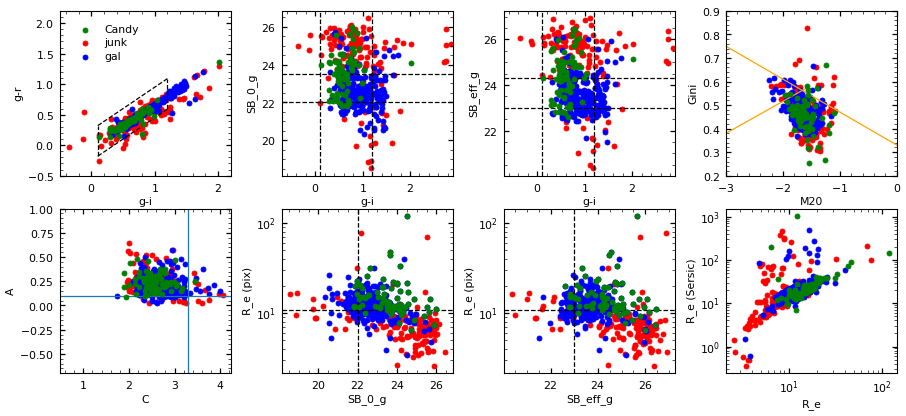

In [15]:
plot_measurement(lsbg_cat, meas_cat)

In [16]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 1.6 / 0.168) & (meas_cat['rhalf_circularized'] < 12 / 0.168)# & (meas_cat['r20'] > 1 / 0.168)
#mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8) # Cuts based on JL votes
#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes
mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0) # Cuts based on JG votes

mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
#mask &= (meas_cat['A_outer'] <= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 57
Gal: 113
Junk: 14


# of Candy: 57
# of Gal: 113
# of Junk: 14


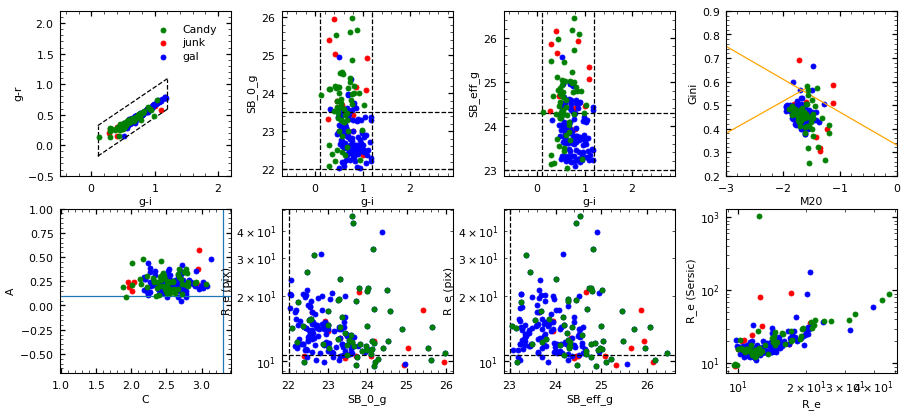

In [17]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

### Save catalog

In [18]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits', overwrite=True)

In [21]:
udg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/UDG_NSA_MW_z002_004_JG.fits')

In [22]:
percentages = []
errors = []

In [25]:
_udg_cat_ind = []
for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(100):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        UDG_num.append(np.sum(flag))
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)
    

400 LSBG candidates in 4 deg2
180 LSBGs after cuts in 4 deg2
4 of them masquerade as UDG

In [26]:
print('Background percentage (%):', 
      round(np.mean(percentages), 2), 
      '+-', round(np.std(percentages), 2), 
      '+-', round(np.mean(errors), 2))

Background percentage (%): 3.47 +- 1.61 +- 0.98


NameError: name 'mass_size_carlsten' is not defined

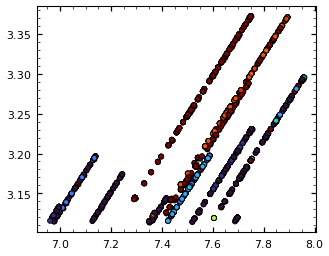

In [36]:
_udg_cat_ind = []
fig, ax = plt.subplots()

for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(50):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        cuts_cat['V_abs'] = V_abs
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        UDG_num.append(np.sum(flag))
        
        _udg_cat = cuts_cat[flag]
        sct = plt.scatter(_udg_cat['log_m_star'], 
                    np.log10(_udg_cat['rhalf_circularized_phys']) + 3, 
                    c=_udg_cat['viz-id'],#_udg_cat['mag'][:, 0] - _udg_cat['mag'][:, 2],
                    label='UDGs')
        
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)
    
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
#plt.legend(loc='lower right')

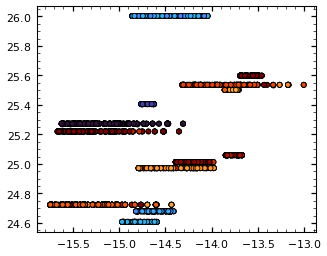

In [204]:
_udg_cat_ind = []
fig, ax = plt.subplots()

for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(50):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        cuts_cat['V_abs'] = V_abs
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        #print(np.sum(flag))
        UDG_num.append(np.sum(flag))
        
        _udg_cat = cuts_cat[flag]
        sct = plt.scatter(_udg_cat['V_abs'], 
                  _udg_cat['SB_0'][:, 0], 
            c=_udg_cat['viz-id'])
        
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)


In [37]:
cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')

In [38]:
(cuts_cat['SB_eff_avg'][:, 0] >= 25.2) == (cuts_cat['SB_0'][:, 0] >= 24.5)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

(-12.0, -16.0)

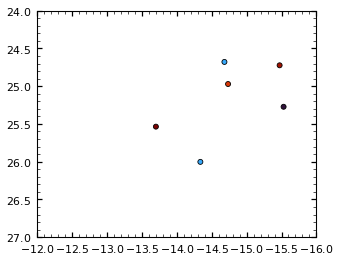

In [195]:
sct = plt.scatter(_udg_cat['V_abs'], 
                  _udg_cat['SB_0'][:, 0], 
            c=_udg_cat['viz-id'])
aa
plt.ylim(27, 24)
plt.xlim(-12, -16)

In [176]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [39]:
np.unique([item for sublist in _udg_cat_ind for item in list(sublist)])

array([ 2448, 12770, 16276, 18684, 18744, 24781, 24804, 30945, 61298,
       64787, 74086, 75211])

In [42]:
temp = lsbg_cat[np.in1d(lsbg_cat['viz-id'], np.unique([item for sublist in _udg_cat_ind for item in list(sublist)]))]

In [44]:
print(temp[['viz-id', 'ra', 'dec']])

viz-id      ra        dec    
------ ----------- ----------
  2448 354.8210365  1.4972768
 12770  353.615214  0.5089902
 16276 354.8874418  -0.197592
 18684 354.0539906  0.5143443
 18744 354.7088539 -0.0051087
 24781 354.7970302  1.0223327
 24804 354.2773338 -0.0599901
 30945 354.1542463  0.3254578
 61298 354.5438796  0.1094843
 64787 354.8992063 -0.3369941
 74086 353.2399377  0.6795777
 75211 354.1548314  0.3246746


In [156]:
from PIL import Image

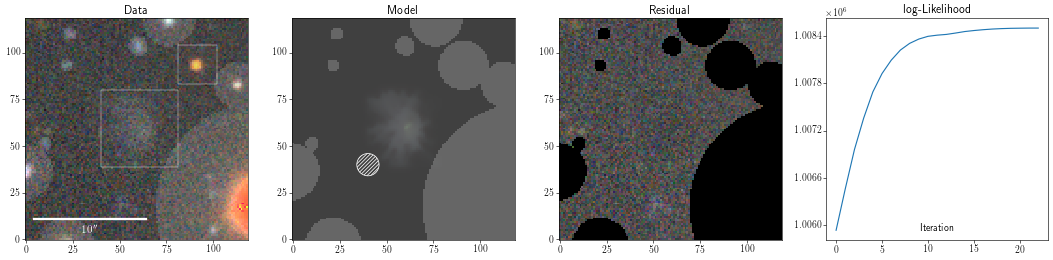

In [175]:
Image.open('./Figure/random_field/random_field-88825-zoomin-vanilla.png')